In [1]:
import numpy as np
import pandas as pd


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import plotly as py
import plotly.graph_objs as go
import os
py.offline.init_notebook_mode(connected = True)
#print(os.listdir("../input"))
import datetime as dt
import missingno as msno
plt.rcParams['figure.dpi'] = 140

In [8]:
df = pd.read_csv("netflix1.csv");

In [10]:
df.head()

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


In [11]:
for i in df.columns:
    null_rate = df[i].isna().sum() / len(df) * 100 
    if null_rate > 0 :
        print("{} null rate: {}%".format(i,round(null_rate,2)))

In [13]:
df.isnull().sum()

show_id         0
type            0
title           0
director        0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   country       8790 non-null   object
 5   date_added    8790 non-null   object
 6   release_year  8790 non-null   int64 
 7   rating        8790 non-null   object
 8   duration      8790 non-null   object
 9   listed_in     8790 non-null   object
dtypes: int64(1), object(9)
memory usage: 686.8+ KB


In [17]:
# For viz: Ratio of Movies & TV shows

x=df.groupby(['type'])['type'].count()
y=len(df)
r=((x/y)).round(2)

mf_ratio = pd.DataFrame(r).T

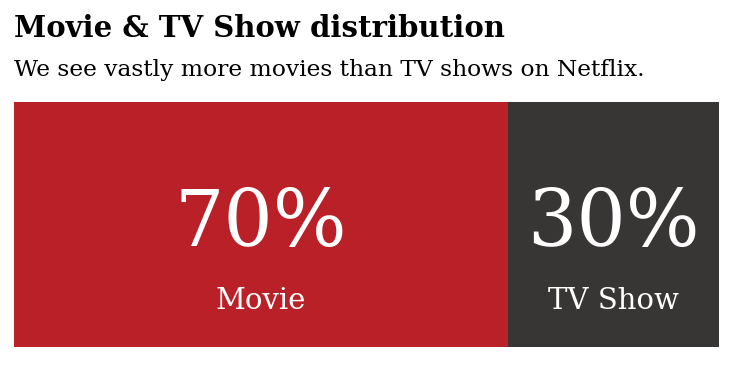

In [18]:

fig, ax = plt.subplots(1,1,figsize=(6.5, 2.5))

ax.barh(mf_ratio.index, mf_ratio['Movie'], 
        color='#b20710', alpha=0.9, label='Male')
ax.barh(mf_ratio.index, mf_ratio['TV Show'], left=mf_ratio['Movie'], 
        color='#221f1f', alpha=0.9, label='Female')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_yticklabels(mf_ratio.index, fontfamily='serif', fontsize=11)


# movie percentage
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['Movie'][i]*100)}%", 
                   xy=(mf_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')

    ax.annotate("Movie", 
                   xy=(mf_ratio['Movie'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')
    
    
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['TV Show'][i]*100)}%", 
                   xy=(mf_ratio['Movie'][i]+mf_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')
    ax.annotate("TV Show", 
                   xy=(mf_ratio['Movie'][i]+mf_ratio['TV Show'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')






# Title & Subtitle
fig.text(0.125,1.03,'Movie & TV Show distribution', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.125,0.92,'We see vastly more movies than TV shows on Netflix.',fontfamily='serif',fontsize=12)  

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    


#ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))

# Removing legend due to labelled plot
ax.legend().set_visible(False)
plt.show()

In [19]:
# Quick feature engineering

# Helper column for various plots
df['count'] = 1

# Many productions have several countries listed - this will skew our results , we'll grab the first one mentioned

# Lets retrieve just the first country
df['first_country'] = df['country'].apply(lambda x: x.split(",")[0])
df['first_country'].head()

# Rating ages from this notebook: https://www.kaggle.com/andreshg/eda-beginner-to-expert-plotly (thank you!)

ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()

# Genre

df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 

# Reducing name length

df['first_country'].replace('United States', 'USA', inplace=True)
df['first_country'].replace('United Kingdom', 'UK',inplace=True)
df['first_country'].replace('South Korea', 'S. Korea',inplace=True)

In [20]:
# Quick feature engineering

# Helper column for various plots
df['count'] = 1

# Many productions have several countries listed - this will skew our results , we'll grab the first one mentioned

# Lets retrieve just the first country
df['first_country'] = df['country'].apply(lambda x: x.split(",")[0])
df['first_country'].head()

# Rating ages from this notebook: https://www.kaggle.com/andreshg/eda-beginner-to-expert-plotly (thank you!)

ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()

# Genre

df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 

# Reducing name length

df['first_country'].replace('United States', 'USA', inplace=True)
df['first_country'].replace('United Kingdom', 'UK',inplace=True)
df['first_country'].replace('South Korea', 'S. Korea',inplace=True)

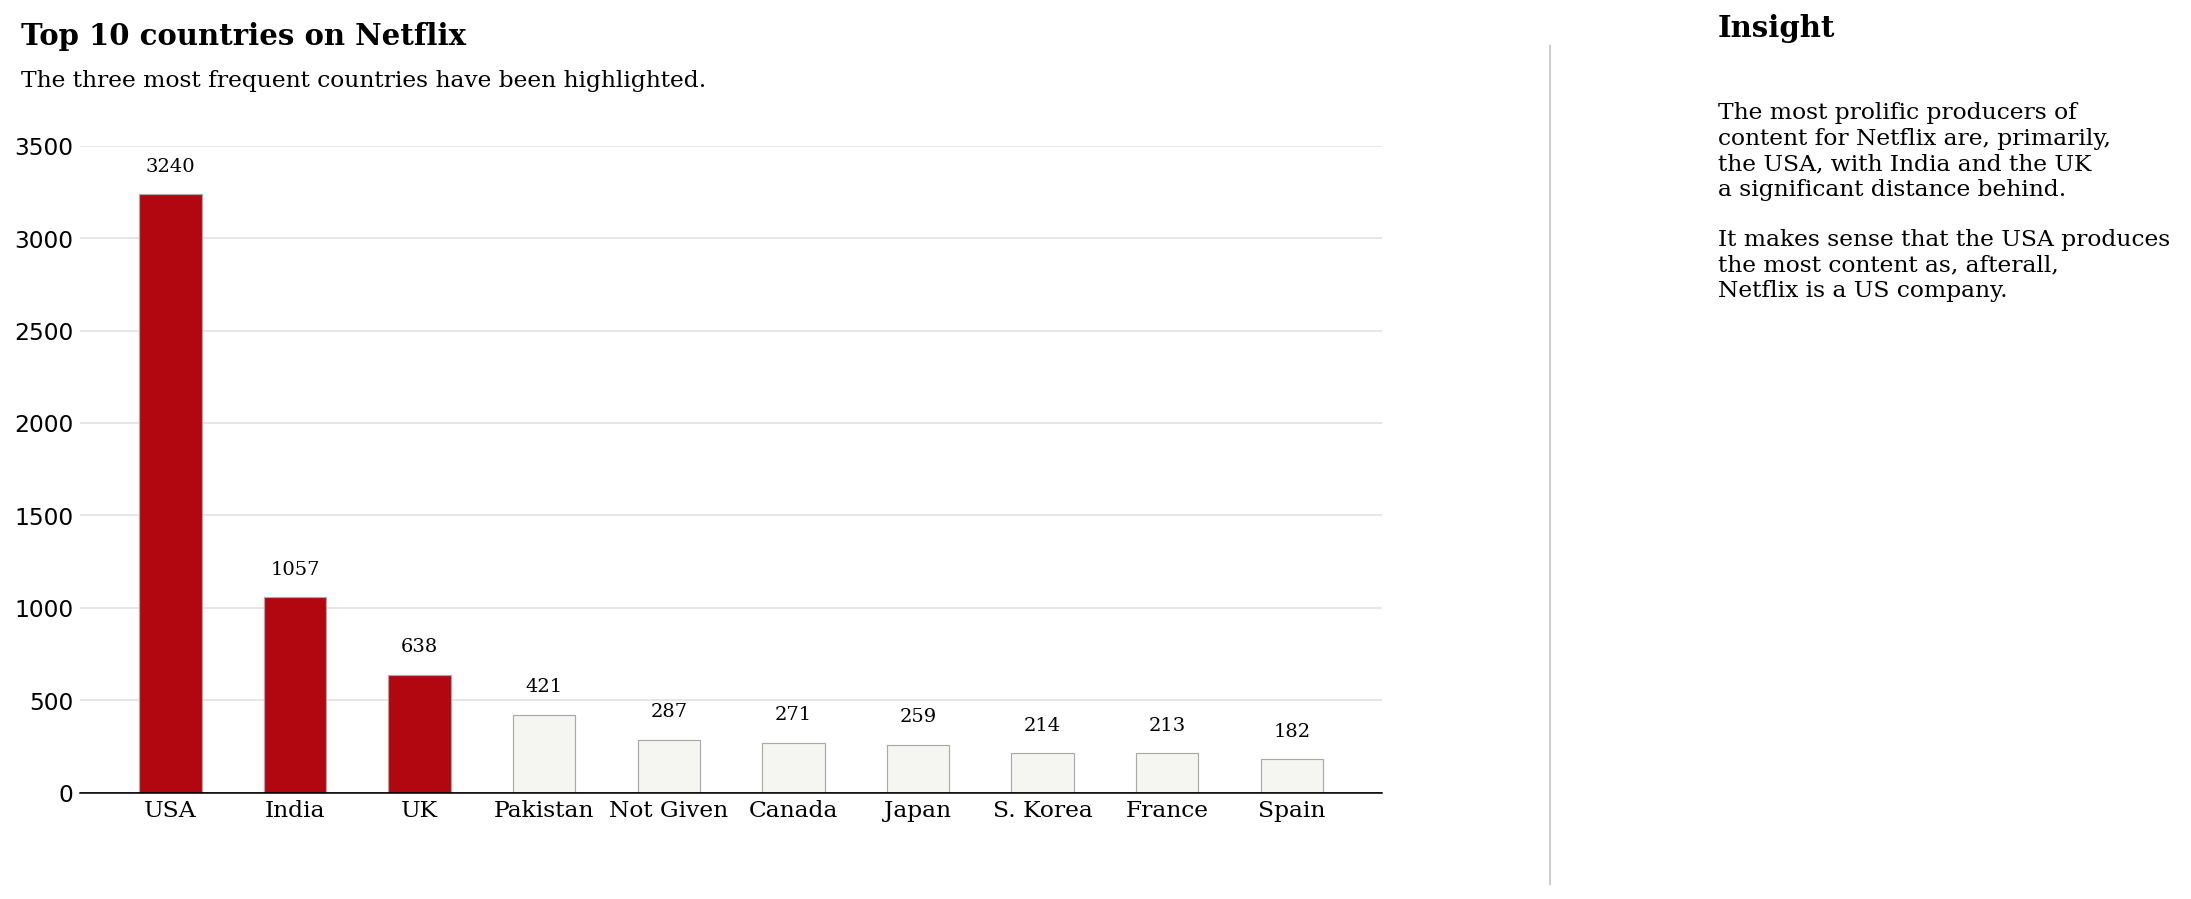

In [21]:
data = df.groupby('first_country')['count'].sum().sort_values(ascending=False)[:10]

# Plot

color_map = ['#f5f5f1' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  '#b20710' # color highlight

fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(data.index, data, width=0.5, 
       edgecolor='darkgray',
       linewidth=0.6,color=color_map)

#annotations
for i in data.index:
    ax.annotate(f"{data[i]}", 
                   xy=(i, data[i] + 150), #i like to change this to roughly 5% of the highest cat
                   va = 'center', ha='center',fontweight='light', fontfamily='serif')



# Remove border from plot

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
# Tick labels

ax.set_xticklabels(data.index, fontfamily='serif', rotation=0)

# Title and sub-title

fig.text(0.09, 1, 'Top 10 countries on Netflix', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 0.95, 'The three most frequent countries have been highlighted.', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(1.1, 1.01, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(1.1, 0.67, '''
The most prolific producers of
content for Netflix are, primarily,
the USA, with India and the UK
a significant distance behind.

It makes sense that the USA produces 
the most content as, afterall, 
Netflix is a US company.
'''
         , fontsize=12, fontweight='light', fontfamily='serif')

ax.grid(axis='y', linestyle='-', alpha=0.4)   

grid_y_ticks = np.arange(0, 4000, 500) # y ticks, min, max, then step
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)

#Axis labels

#plt.xlabel("Country", fontsize=12, fontweight='light', fontfamily='serif',loc='left',y=-1.5)
#plt.ylabel("Count", fontsize=12, fontweight='light', fontfamily='serif')
 #plt.legend(loc='upper right')
    
# thicken the bottom line if you want to
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

ax.tick_params(axis='both', which='major', labelsize=12)


import matplotlib.lines as lines
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

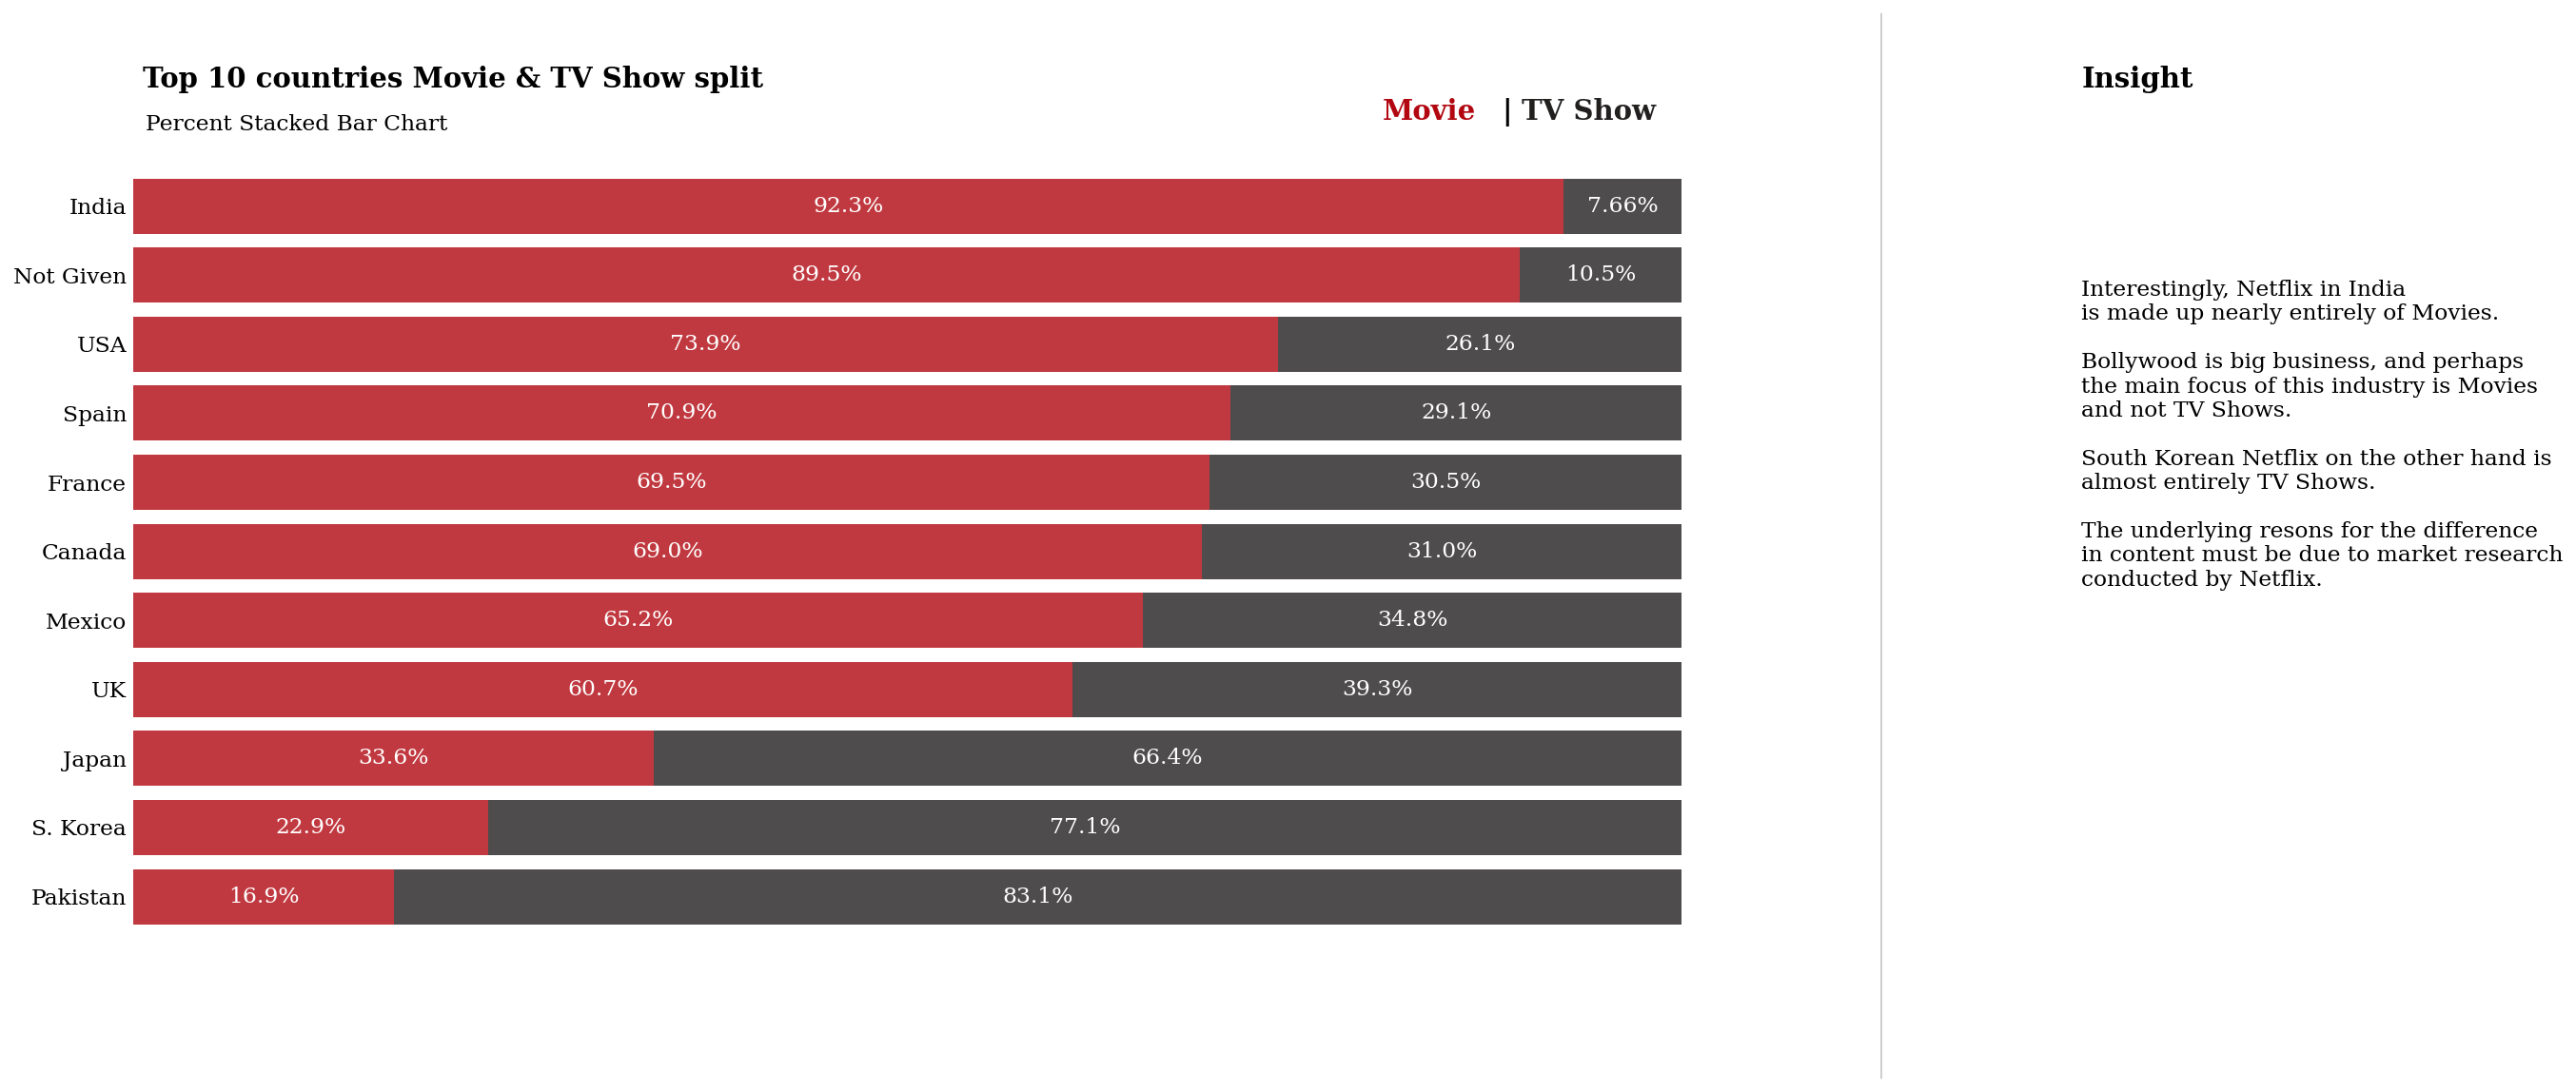

In [22]:
country_order = df['first_country'].value_counts()[:11].index
data_q2q3 = df[['type', 'first_country']].groupby('first_country')['type'].value_counts().unstack().loc[country_order]
data_q2q3['sum'] = data_q2q3.sum(axis=1)
data_q2q3_ratio = (data_q2q3.T / data_q2q3['sum']).T[['Movie', 'TV Show']].sort_values(by='Movie',ascending=False)[::-1]




###
fig, ax = plt.subplots(1,1,figsize=(15, 8),)

ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Movie'], 
        color='#b20710', alpha=0.8, label='Movie')
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['TV Show'], left=data_q2q3_ratio['Movie'], 
        color='#221f1f', alpha=0.8, label='TV Show')


ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(data_q2q3_ratio.index, fontfamily='serif', fontsize=11)

# male percentage
for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['Movie'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['TV Show'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]+data_q2q3_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')
    

fig.text(0.13, 0.93, 'Top 10 countries Movie & TV Show split', fontsize=15, fontweight='bold', fontfamily='serif')   
fig.text(0.131, 0.89, 'Percent Stacked Bar Chart', fontsize=12,fontfamily='serif')   

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
#ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))

fig.text(0.75,0.9,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.81,0.9,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.82,0.9,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')


fig.text(1.1, 0.93, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(1.1, 0.44, '''
Interestingly, Netflix in India
is made up nearly entirely of Movies. 

Bollywood is big business, and perhaps
the main focus of this industry is Movies
and not TV Shows.

South Korean Netflix on the other hand is 
almost entirely TV Shows.

The underlying resons for the difference 
in content must be due to market research
conducted by Netflix.
'''
         , fontsize=12, fontweight='light', fontfamily='serif')



import matplotlib.lines as lines
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])




ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

In [24]:
order = pd.DataFrame(df.groupby('rating')['count'].sum().sort_values(ascending=False).reset_index())
rating_order = list(order['rating'])

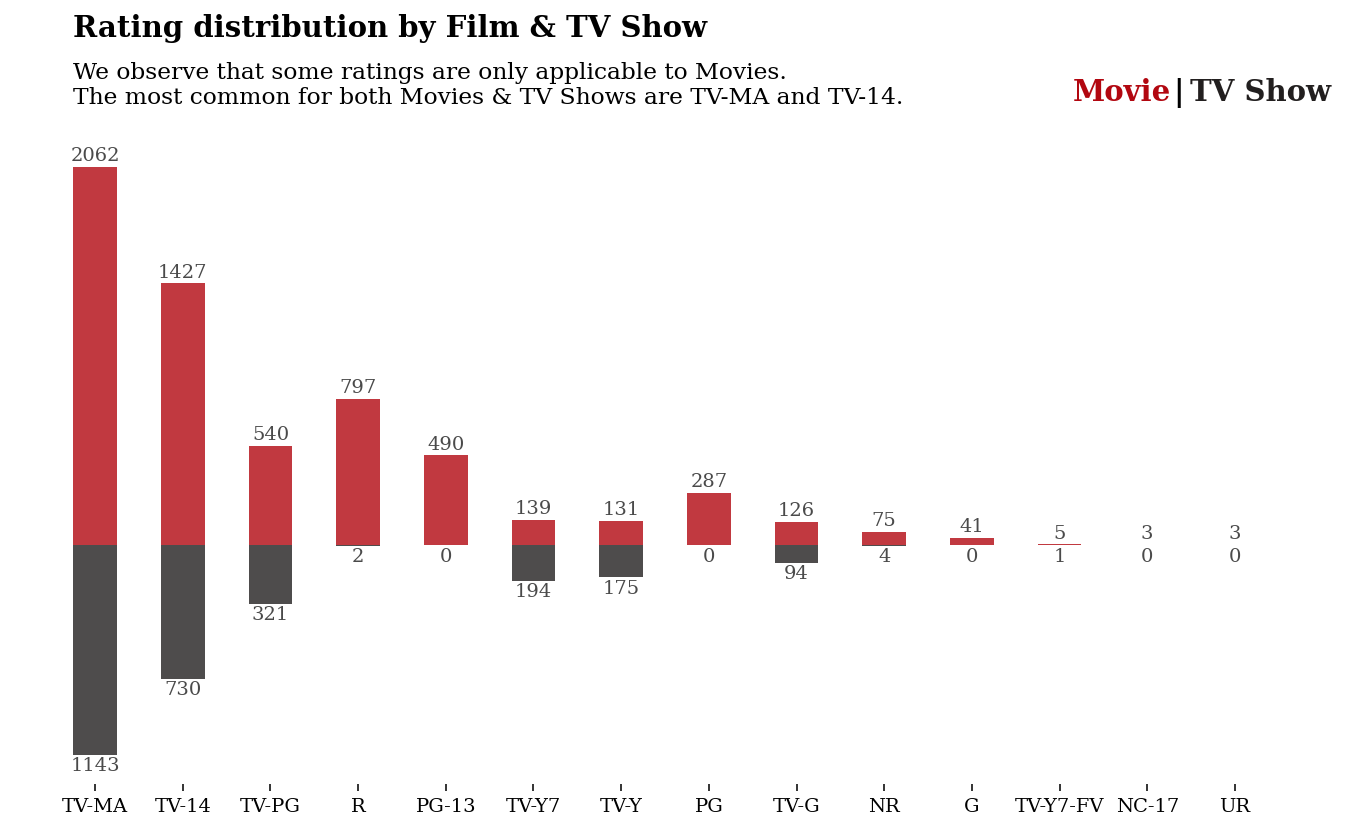

In [25]:
mf = df.groupby('type')['rating'].value_counts().unstack().sort_index().fillna(0).astype(int)[rating_order]

movie = mf.loc['Movie']
tv = - mf.loc['TV Show']


fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(movie.index, movie, width=0.5, color='#b20710', alpha=0.8, label='Movie')
ax.bar(tv.index, tv, width=0.5, color='#221f1f', alpha=0.8, label='TV Show')
#ax.set_ylim(-35, 50)

# Annotations
for i in tv.index:
    ax.annotate(f"{-tv[i]}", 
                   xy=(i, tv[i] - 60),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')   

for i in movie.index:
    ax.annotate(f"{movie[i]}", 
                   xy=(i, movie[i] + 60),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')
    
 

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

ax.set_xticklabels(mf.columns, fontfamily='serif')
ax.set_yticks([])    

ax.legend().set_visible(False)
fig.text(0.16, 1, 'Rating distribution by Film & TV Show', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.16, 0.89, 
'''We observe that some ratings are only applicable to Movies. 
The most common for both Movies & TV Shows are TV-MA and TV-14.
'''

, fontsize=12, fontweight='light', fontfamily='serif')


fig.text(0.755,0.924,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.815,0.924,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.825,0.924,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

plt.show()

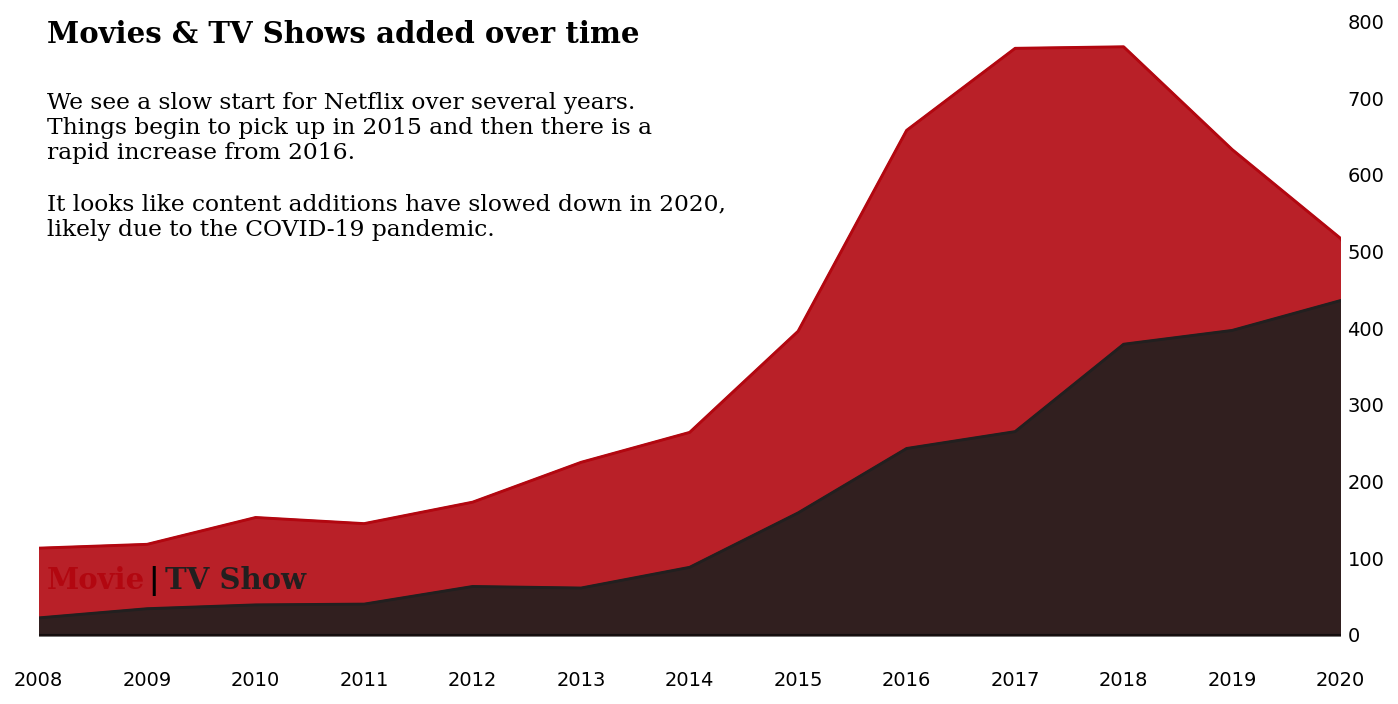

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
color = ["#b20710", "#221f1f"]

for i, mtv in enumerate(df['type'].value_counts().index):
    mtv_rel = df[df['type']==mtv]['release_year'].value_counts().sort_index()
    ax.plot(mtv_rel.index, mtv_rel, color=color[i], label=mtv)
    ax.fill_between(mtv_rel.index, 0, mtv_rel, color=color[i], alpha=0.9)
    
ax.yaxis.tick_right()
    
ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

#ax.set_ylim(0, 50)
#ax.legend(loc='upper left')
for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

ax.grid(False)

ax.set_xlim(2008,2020)
plt.xticks(np.arange(2008, 2021, 1))

fig.text(0.13, 0.85, 'Movies & TV Shows added over time', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.59, 
'''We see a slow start for Netflix over several years. 
Things begin to pick up in 2015 and then there is a 
rapid increase from 2016.

It looks like content additions have slowed down in 2020, 
likely due to the COVID-19 pandemic.
'''

, fontsize=12, fontweight='light', fontfamily='serif')


fig.text(0.13,0.2,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.19,0.2,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.2,0.2,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

In [31]:
# Genres
from sklearn.preprocessing import MultiLabelBinarizer 

import matplotlib.colors


# Custom colour map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710','#f5f5f1'])



def genre_heatmap(df, title):
    df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 
    Types = []
    for i in df['genre']: Types += i
    Types = set(Types)
    print("There are {} types in the Netflix {} Dataset".format(len(Types),title))    
    test = df['genre']
    mlb = MultiLabelBinarizer()
    res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_, index=test.index)
    corr = res.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10, 7))
    fig.text(.54,.88,'Genre correlation', fontfamily='serif',fontweight='bold',fontsize=15)
    fig.text(.75,.665,
            '''
             It is interesting that Independant Movies
             tend to be Dramas. 
             
             Another observation is that 
             Internatinal Movies are rarely
             in the Children's genre.
             ''', fontfamily='serif',fontsize=12,ha='right')
    pl = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, vmin=-.3, center=0, square=True, linewidths=2.5)
    
    plt.show()

There are 20 types in the Netflix Movie Dataset


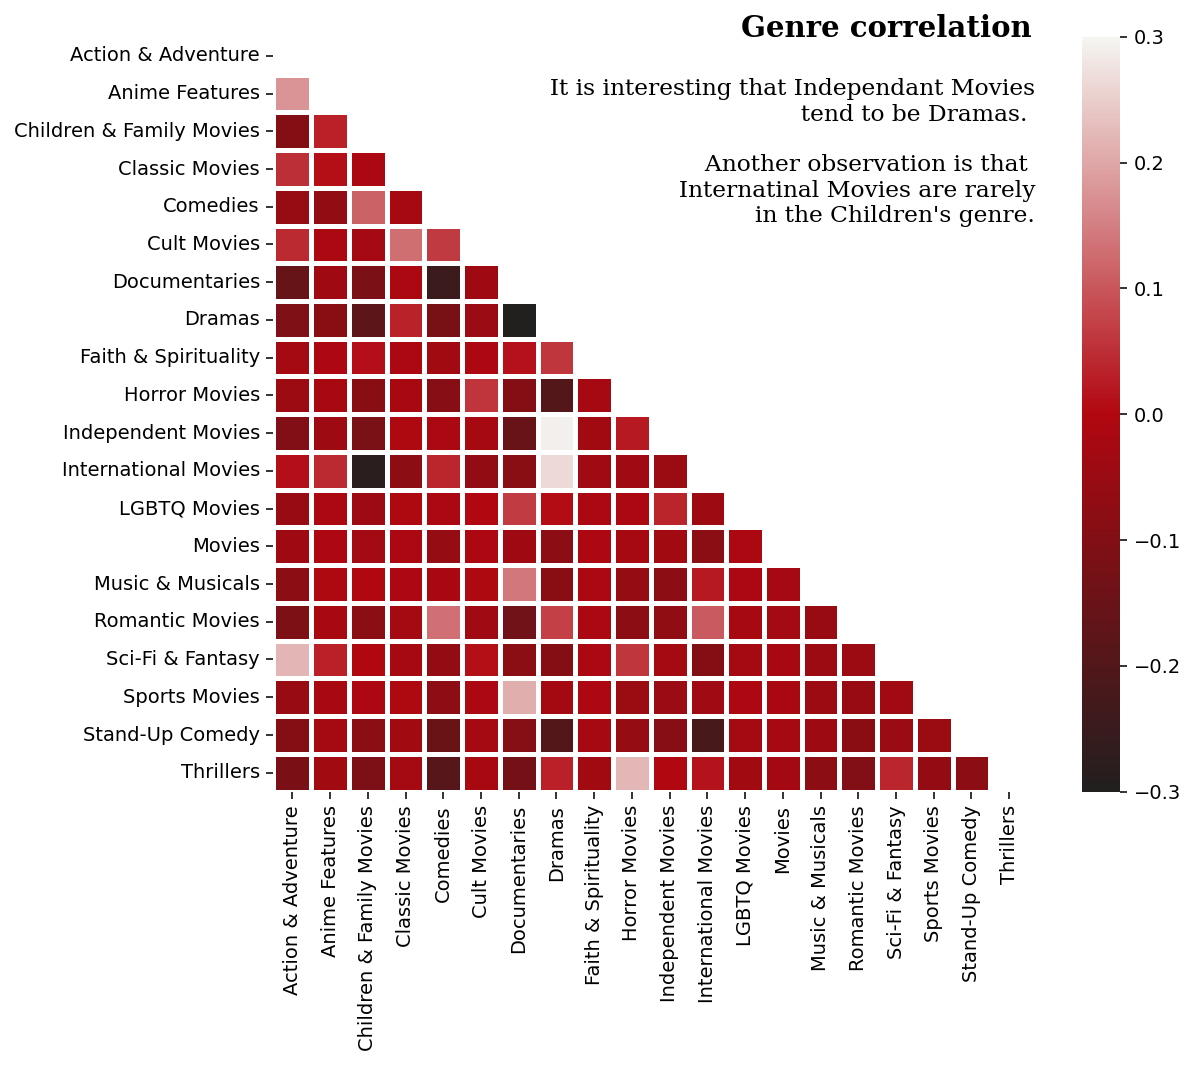

In [32]:
df_tv = df[df["type"] == "TV Show"]
df_movies = df[df["type"] == "Movie"]


genre_heatmap(df_movies, 'Movie')
plt.show()

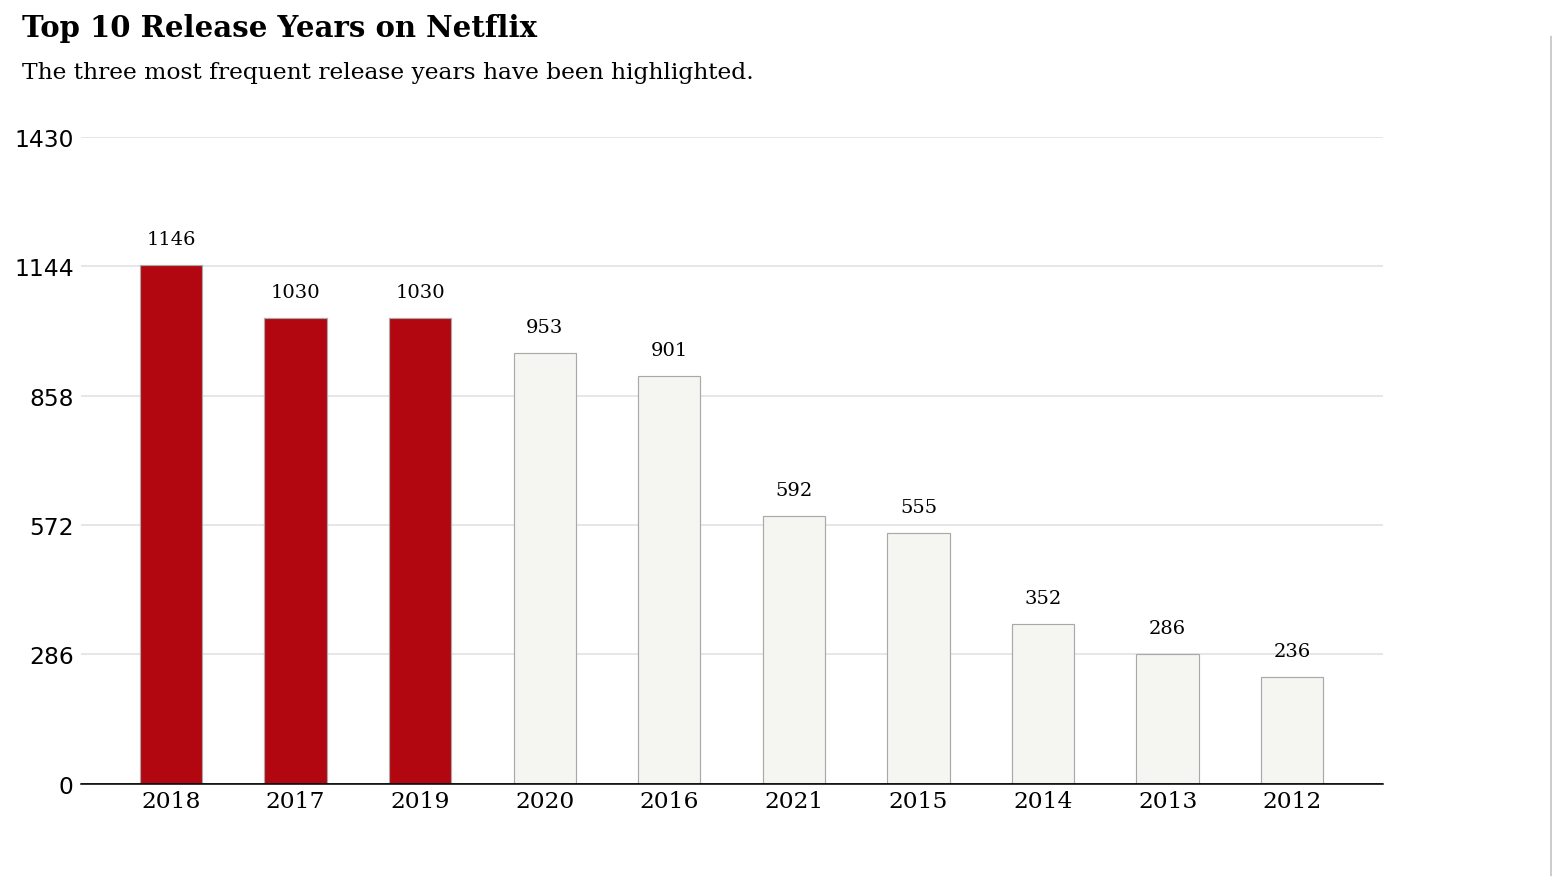

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as lines

# Load your data
df = pd.read_csv('netflix1.csv')

# Group by release year
data = df.groupby('release_year').size().sort_values(ascending=False)[:10]

# Color map (highlight top 3)
color_map = ['#f5f5f1' for _ in range(len(data))]
for i in range(min(3, len(data))):
    color_map[i] = '#b20710'

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.bar(data.index.astype(str), data, width=0.5,
       edgecolor='darkgray',
       linewidth=0.6,
       color=color_map)

# Annotate values (5% above max)
max_val = data.max()
for i in data.index:
    ax.annotate(f"{data[i]}",
                xy=(str(i), data[i] + 0.05 * max_val),
                va='center', ha='center',
                fontweight='light', fontfamily='serif')

# Remove top, left, right spines
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

# X ticks
ax.set_xticklabels(data.index.astype(str), fontfamily='serif', rotation=0)

# Titles
fig.text(0.09, 1, 'Top 10 Release Years on Netflix', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 0.95, 'The three most frequent release years have been highlighted.', fontsize=12, fontweight='light', fontfamily='serif')



# Grid and axis settings
ax.grid(axis='y', linestyle='-', alpha=0.4)
ax.set_axisbelow(True)

# Y ticks
max_y = max_val + 1
step = max(1, max_val // 4)
ax.set_yticks(np.arange(0, max_y + step, step))

# Bottom border
plt.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='both', length=0)

# Vertical line separator
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig, color='black', lw=0.2)
fig.lines.extend([l1])

plt.show()


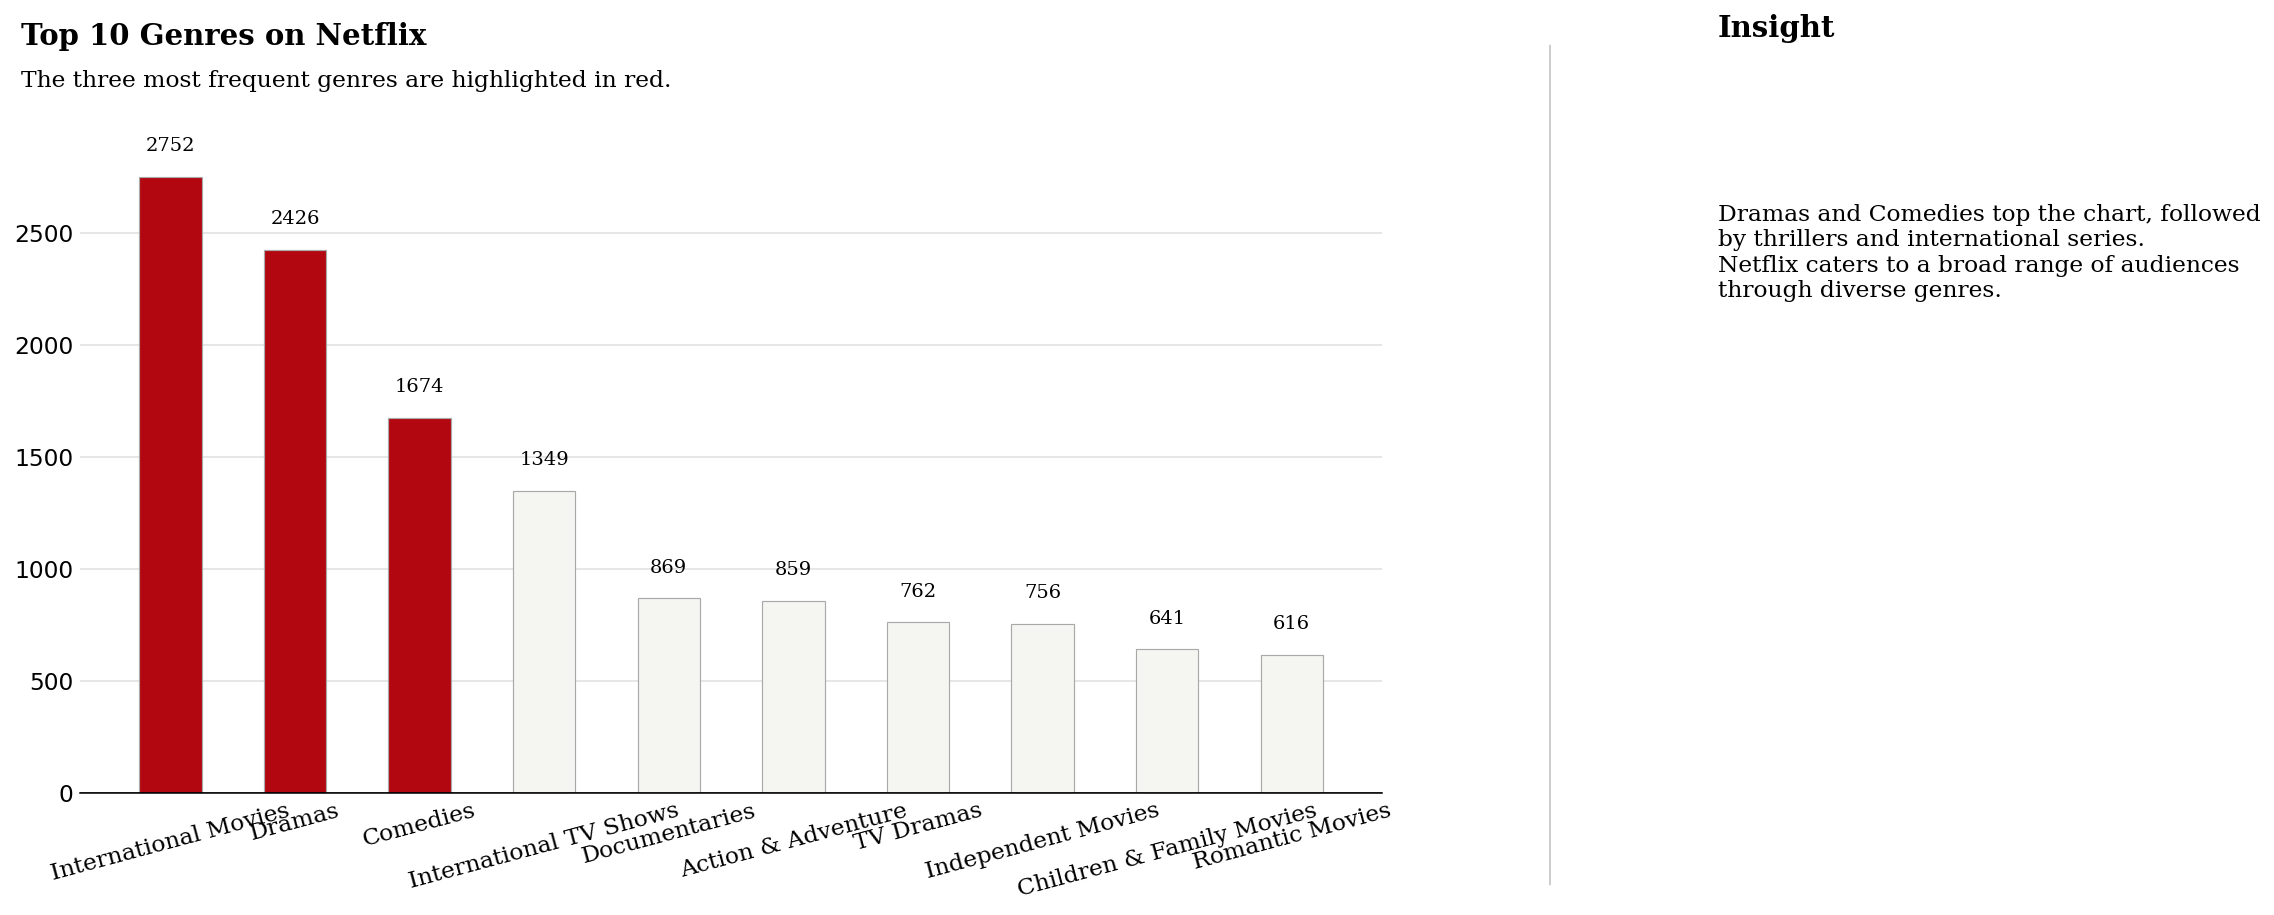

In [41]:
# Explode the genres column
genre_series = df['listed_in'].dropna().str.split(', ')
genre_flat = genre_series.explode()
genre_counts = genre_flat.value_counts().head(10)

# Color map
color_map = ['#f5f5f1' for _ in range(len(genre_counts))]
for i in range(min(3, len(genre_counts))):
    color_map[i] = '#b20710'

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(genre_counts.index, genre_counts.values, width=0.5, color=color_map, edgecolor='darkgray', linewidth=0.6)

# Annotate
max_val = genre_counts.max()
for i, val in enumerate(genre_counts.values):
    ax.annotate(f"{val}", (i, val + 0.05 * max_val), ha='center', va='center', fontweight='light', fontfamily='serif')

# Aesthetic settings
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.set_xticklabels(genre_counts.index, fontfamily='serif', rotation=15)

fig.text(0.09, 1, 'Top 10 Genres on Netflix', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 0.95, 'The three most frequent genres are highlighted in red.', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(1.1, 1.01, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(1.1, 0.67, '''
Dramas and Comedies top the chart, followed
by thrillers and international series.
Netflix caters to a broad range of audiences
through diverse genres.
''', fontsize=12, fontweight='light', fontfamily='serif')

ax.grid(axis='y', linestyle='-', alpha=0.4)
ax.set_axisbelow(True)
plt.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='both', length=0)

l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig, color='black', lw=0.2)
fig.lines.extend([l1])

plt.show()
